In [ ]:
!pip install gdown timm tqdm torchinfo --quiet

import gdown
file_id = '123456789'  # Replace with the actual file ID
output = '/content/Insect_Dataset.tar.xz'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
print("Dataset downloaded!")

Downloading...
From (original): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA
From (redirected): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA&confirm=t&uuid=6163aed8-3fc7-4f4b-90df-640601d80347
To: /content/Insect_Dataset.tar.xz
100%|██████████| 654M/654M [00:09<00:00, 66.1MB/s]

Dataset downloaded!


In [2]:
!tar -xf Insect_Dataset.tar.xz
print("Extraction complete!")

Extraction complete!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os, random, shutil
from tqdm import tqdm
import torchinfo

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64  # EfficientFormer is very memory efficient → larger batch!

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms ready (optimized for EfficientFormer)")

Transforms ready (optimized for EfficientFormer)


In [5]:
data_dir = '/content/Insect_Dataset'
split_dir = '/content/Insect_Dataset_Split'
os.makedirs(split_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_dir, split), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    n = len(images)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)

    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }

    for split_name, img_list in splits.items():
        dest_dir = os.path.join(split_dir, split_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for img in img_list:
            shutil.copy2(os.path.join(class_path, img), dest_dir)

print("Dataset split complete!")

Dataset split complete!


In [6]:
data_dir_split = '/content/Insect_Dataset_Split'

train_dataset = datasets.ImageFolder(os.path.join(data_dir_split, 'train'), train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir_split, 'val'),   val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir_split, 'test'),  val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Classes: {num_classes}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)} samples")

Classes: 15
Train: 12518, Val: 1559, Test: 1577 samples


In [7]:
# Best model: efficientformer_l1 (12M params, 81.5% ImageNet)
model = timm.create_model('efficientformer_l1', pretrained=True, num_classes=num_classes)

# Other options:
# model = timm.create_model('efficientformer_l3', pretrained=True, num_classes=num_classes)  # better acc
# model = timm.create_model('efficientformer_l7', pretrained=True, num_classes=num_classes)  # even better

print("EfficientFormer-L1 loaded!")
torchinfo.summary(model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

EfficientFormer-L1 loaded!


Layer (type:depth-idx)                             Output Shape              Param #
EfficientFormer                                    [1, 15]                   --
├─Stem4: 1-1                                       [1, 48, 56, 56]           --
│    └─Conv2d: 2-1                                 [1, 24, 112, 112]         672
│    └─BatchNorm2d: 2-2                            [1, 24, 112, 112]         48
│    └─ReLU: 2-3                                   [1, 24, 112, 112]         --
│    └─Conv2d: 2-4                                 [1, 48, 56, 56]           10,416
│    └─BatchNorm2d: 2-5                            [1, 48, 56, 56]           96
│    └─ReLU: 2-6                                   [1, 48, 56, 56]           --
├─Sequential: 1-2                                  [1, 49, 448]              --
│    └─EfficientFormerStage: 2-7                   [1, 48, 56, 56]           --
│    │    └─Identity: 3-1                          [1, 48, 56, 56]           --
│    │    └─Sequential: 3-2   

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print(f"Training on {device} | Batch size: {BATCH_SIZE}")

Training on cuda | Batch size: 64


In [9]:
EPOCHS = 20
best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    train_loss = 0.0
    correct = total = 0
    loop = tqdm(train_loader, leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

        loop.set_postfix(loss=f"{train_loss/(loop.n+1):.4f}",
                        acc=f"{100.*correct/total:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

    val_acc = 100. * correct / total
    scheduler.step()

    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Acc: {100.*correct/total:.2f}%")
    print(f"Val   Loss: {val_loss/len(val_loader):.4f} | Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientformer_l1.pth')
        print(f"Best model saved! Val Acc: {best_acc:.2f}%")

print(f"\nTraining Complete! Best Val Acc: {best_acc:.2f}%")


Epoch 1/20


Train Loss: 1.3817 | Acc: 67.29%
Val   Loss: 1.3837 | Acc: 67.29%
Best model saved! Val Acc: 67.29%

Epoch 2/20


Train Loss: 1.0123 | Acc: 75.82%
Val   Loss: 1.1827 | Acc: 75.82%
Best model saved! Val Acc: 75.82%

Epoch 3/20


Train Loss: 0.8748 | Acc: 74.34%
Val   Loss: 1.2679 | Acc: 74.34%

Epoch 4/20


Train Loss: 0.8073 | Acc: 79.41%
Val   Loss: 1.0978 | Acc: 79.41%
Best model saved! Val Acc: 79.41%

Epoch 5/20


Train Loss: 0.7514 | Acc: 80.05%
Val   Loss: 1.0890 | Acc: 80.05%
Best model saved! Val Acc: 80.05%

Epoch 6/20


Train Loss: 0.7108 | Acc: 78.19%
Val   Loss: 1.1320 | Acc: 78.19%

Epoch 7/20


Train Loss: 0.6921 | Acc: 79.60%
Val   Loss: 1.1096 | Acc: 79.60%

Epoch 8/20


Train Loss: 0.6611 | Acc: 80.82%
Val   Loss: 1.0864 | Acc: 80.82%
Best model saved! Val Acc: 80.82%

Epoch 9/20


Train Loss: 0.6453 | Acc: 80.24%
Val   Loss: 1.1183 | Acc: 80.24%

Epoch 10/20


Train Loss: 0.6316 | Acc: 82.49%
Val   Loss: 1.0513 | Acc: 82.49%
Best model saved! Val Acc: 82.49%

Epoch 11/20


Train Loss: 0.6163 | Acc: 81.72%
Val   Loss: 1.0798 | Acc: 81.72%

Epoch 12/20


Train Loss: 0.6057 | Acc: 80.95%
Val   Loss: 1.1036 | Acc: 80.95%

Epoch 13/20


Train Loss: 0.5954 | Acc: 82.68%
Val   Loss: 1.0546 | Acc: 82.68%
Best model saved! Val Acc: 82.68%

Epoch 14/20


Train Loss: 0.5942 | Acc: 83.71%
Val   Loss: 1.0357 | Acc: 83.71%
Best model saved! Val Acc: 83.71%

Epoch 15/20


Train Loss: 0.5891 | Acc: 83.84%
Val   Loss: 1.0274 | Acc: 83.84%
Best model saved! Val Acc: 83.84%

Epoch 16/20


Train Loss: 0.5865 | Acc: 83.19%
Val   Loss: 1.0388 | Acc: 83.19%

Epoch 17/20


Train Loss: 0.5814 | Acc: 84.09%
Val   Loss: 1.0256 | Acc: 84.09%
Best model saved! Val Acc: 84.09%

Epoch 18/20


Train Loss: 0.5817 | Acc: 83.84%
Val   Loss: 1.0300 | Acc: 83.84%

Epoch 19/20


Train Loss: 0.5793 | Acc: 83.71%
Val   Loss: 1.0273 | Acc: 83.71%

Epoch 20/20


Train Loss: 0.5776 | Acc: 83.71%
Val   Loss: 1.0278 | Acc: 83.71%

Training Complete! Best Val Acc: 84.09%


In [10]:
model.load_state_dict(torch.load('best_efficientformer_l1.pth'))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=4))


Classification Report
                            precision    recall  f1-score   support

Mango flat beak leafhopper     0.9123    0.9286    0.9204        56
         alfalfa plant bug     0.9861    0.8659    0.9221        82
            alfalfa weevil     0.8627    0.8148    0.8381       108
                 army worm     0.9111    0.9244    0.9177       410
        asiatic rice borer     0.7500    0.5882    0.6593        51
                  beet fly     0.9277    0.9625    0.9448        80
        brown plant hopper     0.7921    0.8889    0.8377        90
                corn borer     0.9020    0.8519    0.8762       108
                 green bug     0.7377    0.6250    0.6767        72
         paddy stem maggot     0.6639    0.7453    0.7022       106
          rice leaf roller     0.7619    0.6400    0.6957        50
           rice shell pest     0.9432    0.9651    0.9540        86
       tarnished plant bug     0.9648    0.9786    0.9716       140
       white margined mo

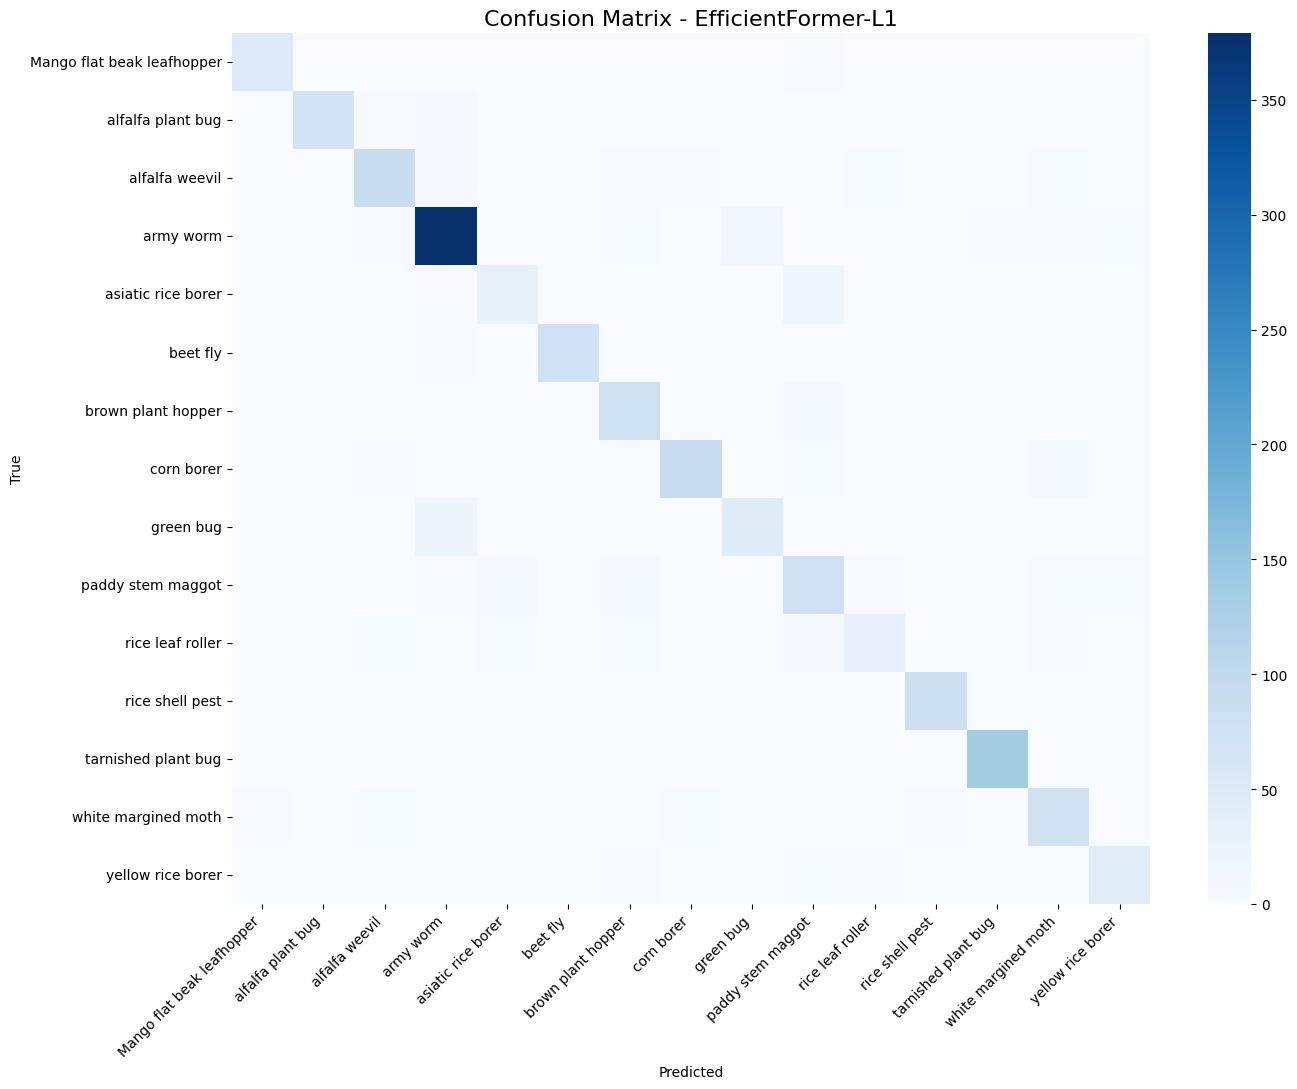

In [11]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 11))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title("Confusion Matrix - EfficientFormer-L1", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
!pip install onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 11.0 MB/s eta 0:00:00


In [15]:
# Save full model
torch.save(model, 'efficientformer_l1_insect_full.pth')

# Export to ONNX
dummy = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy, "efficientformer_l1_insect.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}})
print("ONNX exported!")

/tmp/ipython-input-3219656458.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model, dummy, "efficientformer_l1_insect.onnx",


[torch.onnx] Obtain model graph for `EfficientFormer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EfficientFormer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 35 of general pattern rewrite rules.
ONNX exported!
